#FAOSTAT Producer Prices:

#ETL & Initial Data Exploration
This notebook implements an Extract, Transform, Load (ETL) pipeline to programmatically fetch agricultural producer price data from the FAOSTAT API. The primary objective is to acquire clean, structured, and consistent annual price data for selected countries across North, Central, and South America.

Beyond the core ETL process, this notebook also incorporates initial data analysis and visualization. These integrated visuals are designed to provide a better, immediate understanding of the extracted data's key trends, distributions, and regional insights. This approach enhances the clarity of the data engineering workflow by providing instant feedback on the processed dataset, while still allowing for more in-depth analysis in separate environments if needed.

Finally, the processed and explored data will be stored in Google Drive for further use.

Prerequisites
To run this notebook, ensure you are in a Google Colab environment and have mounted your Google Drive, as the script will attempt to save the processed data there.

In [2]:
# --- Mount Google Drive ---
# This is a necessary action in Google Colab to access your Drive files.
from google.colab import drive
drive.mount('/content/drive')

# --- Import all necessary libraries for the notebook ---

import requests  # For making HTTP requests to the FAOSTAT API
import pandas as pd  # For manipulating data in DataFrames
import io  # For handling the response content as a file
import os  # For interacting with the file system (creating folders, joining paths)
from datetime import datetime  # For generating the timestamp in the file name

Mounted at /content/drive


# 1. Define FAOSTAT API Parameters
This section defines all the necessary parameters for the FAOSTAT API request. These values are crucial as they directly correspond to the filters and selections made on the FAOSTAT website's data download interface. If the data filters on FAOSTAT change, these parameters will need to be updated to reflect the new criteria.

* **AREA_CODES_EXPANDED**:
 Specifies the countries/regions to include in the data extraction. This expanded list ensures broader coverage for later regional categorization.

* **ELEMENT_CODE**:
Defines the specific type of data to be extracted, which in this case is 'Producer Price (USD/tonne)'.

* **ITEM_CODES**:
Represents the specific agricultural commodities (products) for which price data is requested.

* **YEAR_CODES**:
Sets the desired annual range for the data. The current range (2000-2024) provides a comprehensive historical context, allowing for both long-term trend analysis and focused insights on recent periods as needed.

* **MONTH_CODE**:
Specifies the temporal aggregation, set to 'Annual value'.

* **Other parameters**
(AREA_CS, ITEM_CS, SHOW_CODES, SHOW_UNIT, SHOW_FLAGS, SHOW_NOTES, NULL_VALUES, OUTPUT_TYPE) control the output format and the inclusion of additional metadata or handling of null values from the API response.

# 2. Data Extraction from FAOSTAT API
This section initiates the data extraction process. It constructs the full API request URL using the defined parameters and performs an HTTP GET request to the FAOSTAT service. The response, expected in CSV format, is then loaded directly into a pandas DataFrame.

Robust error handling is included to catch common issues such as HTTP errors (e.g., 404 Not Found, 500 Server Error) or general request exceptions (e.g., network connectivity problems), providing informative messages to aid in debugging.

# 3. Data Cleaning and Transformation

This section focuses on refining the extracted DataFrame to make it more suitable for analysis and visualization. It includes several crucial steps:

* **Column Renaming:** Enhances clarity and consistency by renaming columns to more descriptive names (e.g., 'Area' to 'Country', 'Value' to 'Producer_Price_USD_tonne').
* **Irrelevant Column Removal:** Removes columns that provide redundant or unnecessary information for the current scope (e.g., the 'Months' column if it uniformly contains 'Annual value').
* **Post-extraction Country Filtering:** Filters the DataFrame to remove specific non-American countries (e.g., "Côte d'Ivoire", "Ethiopia", etc.) that might have been included in the initial broad data pull, ensuring the dataset focuses solely on American regions.
* **Region Categorization:** A crucial transformation that adds a new 'Region' column. This categorizes each remaining country into 'North America', 'Central America', or 'South America', enabling more granular regional-level analysis. The categorization logic is defined within a helper function.
* **Zero Value Handling:** Includes a check and warning for zero values in the 'Producer_Price_USD_tonne' column. For producer prices, a zero might genuinely indicate no production or specific market conditions rather than missing data. This step highlights such occurrences for review, but does not alter them unless explicitly required by business logic. It's important to note that during the initial data filtering from the FAOSTAT website, the option to exclude null values was selected, aiming to receive a cleaner dataset directly from the source.
* **Column Reordering:** Arranges the columns in a more logical and readable order for improved data presentation and usability.

In [86]:


# --- 1. Define the download URL parameters ---

# These codes and values were extracted directly from the "Request URL" obtained
# by clicking on "Download Data" in the FAOSTAT interface, with the applied filters.
# If the selected filters on the FAOSTAT website change, you will need to update these values.

# Main filter parameters (correspond to your selections in the FAOSTAT interface)
# -------------------------------------------------------------------------------------
# 'area': Codes of selected countries/areas (e.g., Argentina, Brazil, USA, Canada, etc.)
# Expanded AREA_CODES to include more specific regional breakdowns for later categorization
# Keeping the original broad AREA_CODES_EXPANDED to allow for post-extraction filtering
AREA_CODES_EXPANDED = "9,19,21,33,40,44,48,56,58,60,66,89,95,101,107,136,138,150,157,161,166,169,170,175,211,231,234,236,238"


# 'element': Data type code (e.g., '5532' for 'Producer Price (USD/tonne)')
ELEMENT_CODE = "5532"

# 'item': Codes of selected agricultural products/commodities (e.g., Corn, Soy, Bananas, etc.)
ITEM_CODES = "572,486,44,552,661,656,767,1062,497,56,571,1058,1035,836,402,490,116,547,27,236,544,157,267,388,15"

# 'year': Range or list of selected years (e.g., 2000,2001,...,2024)
YEAR_CODES = "2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024"

# 'month': Selected temporal aggregation (e.g., '7021' for 'Annual value')
MONTH_CODE = "7021"

# Additional parameters present in the FAOSTAT download URL (output configurations)
# -------------------------------------------------------------------------------------------
# 'area_cs': Area classification scheme (e.g., 'M49' for M49 codes)
AREA_CS = "M49"
# 'item_cs': Item classification scheme (e.g., 'CPC' for Central Product Classification)
ITEM_CS = "CPC"
# 'show_codes': Whether to include item/area codes in the output (false/true)
SHOW_CODES = "false"
# 'show_unit': Whether to include the unit column in the output (false/true)
SHOW_UNIT = "true"
# 'show_flags': Whether to include data flags/notes in the output (false/true)
SHOW_FLAGS = "false"
# 'show_notes': Whether to include footnotes in the output (false/true)
SHOW_NOTES = "true"
# 'null_values': How to handle null values (false/true)
NULL_VALUES = "false"
# 'output_type': Desired output format (e.g., 'csv')
OUTPUT_TYPE = "csv"

# --- 2. Construct the base FAOSTAT API URL for "Producer Prices" ---

BASE_API_URL = "https://faostatservices.fao.org/api/v1/en/data/PP"

# Create a dictionary with all parameters for the GET request
params = {
    "area": AREA_CODES_EXPANDED, # Using expanded area codes
    "area_cs": AREA_CS,
    "element": ELEMENT_CODE,
    "item": ITEM_CODES,
    "item_cs": ITEM_CS,
    "year": YEAR_CODES,
    "month": MONTH_CODE,
    "show_codes": SHOW_CODES,
    "show_unit": SHOW_UNIT,
    "show_flags": SHOW_FLAGS,
    "show_notes": SHOW_NOTES,
    "null_values": NULL_VALUES,
    "output_type": OUTPUT_TYPE
}

print("--- Starting FAOSTAT Data Extraction ---")
print(f"Requesting data for {len(AREA_CODES_EXPANDED.split(','))} countries and {len(ITEM_CODES.split(','))} items.")
print(f"Years: {YEAR_CODES.split(',')[0]} - {YEAR_CODES.split(',')[-1]}")
print(f"Aggregation: Annual (code {MONTH_CODE})")
print(f"Element: Producer Price (USD/tonne) (code {ELEMENT_CODE})")


# --- 3. Perform the HTTP GET request and load into DataFrame ---

try:
    # requests.get() will automatically encode the parameters and append them to the URL
    response = requests.get(BASE_API_URL, params=params)
    response.raise_for_status() # Raises an exception for HTTP errors (4xx or 5xx)

    # Load the CSV content directly into a pandas DataFrame
    data = io.StringIO(response.text)
    df = pd.read_csv(data)

    print("\n--- Extraction and Processing Completed ---")

    # --- 4. Clean and format the DataFrame ---
    # Remove the 'Months' column if it's already known to be 'Annual value' and adds no information
    if 'Months' in df.columns and df['Months'].nunique() == 1 and df['Months'].iloc[0] == 'Annual value':
        df = df.drop(columns=['Months'])

    # Rename columns for clarity and consistency with the report
    df = df.rename(columns={
        'Area': 'Country',
        'Item': 'Commodity',
        'Element': 'Price_Element', # Rename to avoid confusion with other 'elements'
        'Value': 'Producer_Price_USD_tonne' # Rename the value to be more descriptive
    })

    # --- Data Cleaning and Transformation (Post-extraction filtering and Region creation) ---

    # Define the list of non-American countries to be removed
    countries_to_remove = [
        "Côte d'Ivoire",
        "Ethiopia",
        "Fiji",
        "Guinea-Bissau",
        "Indonesia",
        "Netherlands (Kingdom of the)",
        "Switzerland"
    ]

    # Remove rows where the 'Country' is in the `countries_to_remove` list
    initial_rows = len(df)
    df = df[~df['Country'].isin(countries_to_remove)].copy()
    rows_removed = initial_rows - len(df)
    if rows_removed > 0:
        print(f"Removed {rows_removed} rows corresponding to non-American countries.")

    # Define a function to categorize countries into regions
    def assign_region(country):
        north_america = ['Canada', 'Mexico', 'United States of America']
        central_america = ['Costa Rica', 'Dominican Republic', 'El Salvador', 'Honduras', 'Nicaragua', 'Panama']
        south_america = [
            'Argentina', 'Bolivia (Plurinational State of)', 'Brazil', 'Chile',
            'Colombia', 'Ecuador', 'Paraguay', 'Peru', 'Uruguay',
            'Venezuela (Bolivarian Republic of)'
        ]
        if country in north_america:
            return 'North America'
        elif country in central_america:
            return 'Central America'
        elif country in south_america:
            return 'South America'
        else:
            return 'Other/Uncategorized' # For any countries that might slip through or not be defined

    # Create the 'Region' column
    df['Region'] = df['Country'].apply(assign_region)

    # Check for and handle zero values in 'Producer_Price_USD_tonne'
    zero_price_rows = df[df['Producer_Price_USD_tonne'] == 0].shape[0]
    if zero_price_rows > 0:
        print(f"Warning: {zero_price_rows} rows have 'Producer_Price_USD_tonne' as 0. Review if this indicates missing data.")

    # Reorder columns for better readability (optional) - including 'Region'
    desired_columns_order = [
        'Domain', 'Country', 'Region', 'Commodity', 'Year', 'Price_Element', 'Unit', 'Producer_Price_USD_tonne',
        'Element Code', 'Item Code', 'Area Code', # Include codes if desired for reference
        'Flag', 'Note' # If show_flags/show_notes are true and exist
    ]
    # Filter only columns that actually exist in the DataFrame
    df = df[[col for col in desired_columns_order if col in df.columns]]

    # --- 5. Display the first rows of the DataFrame ---
    print("\nFirst 5 rows of the resulting DataFrame (with Region):")
    print(df.head())
    print(f"\nDataFrame loaded with {len(df)} rows and {len(df.columns)} columns.")
    print("\nSummary statistics for Producer_Price_USD_tonne:")
    print(df['Producer_Price_USD_tonne'].describe())

    # Display unique Country-Region pairs
    if 'df' in locals():
        country_region_df = df[['Country', 'Region']]
        print("\nUnique Country-Region pairs (after filtering and categorization):")
        print(country_region_df.drop_duplicates().sort_values(by=['Region', 'Country']).reset_index(drop=True))
    else:
        print("DataFrame 'df' not found. Please ensure the data extraction and cleaning steps have been run.")

except requests.exceptions.HTTPError as http_err:
    print(f"HTTP error occurred: {http_err}")
    print(f"Request URL: {response.url}")
    print(f"Server response (first 500 characters): {response.text[:500]}...")
except requests.exceptions.RequestException as req_err:
    print(f"Request error (e.g., connection issues): {req_err}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Starting FAOSTAT Data Extraction ---
Requesting data for 29 countries and 25 items.
Years: 2000 - 2024
Aggregation: Annual (code 7021)
Element: Producer Price (USD/tonne) (code 5532)

--- Extraction and Processing Completed ---
Removed 1380 rows corresponding to non-American countries.

First 5 rows of the resulting DataFrame (with Region):
            Domain    Country         Region Commodity  Year  \
0  Producer Prices  Argentina  South America   Bananas  2000   
1  Producer Prices  Argentina  South America   Bananas  2001   
2  Producer Prices  Argentina  South America   Bananas  2002   
3  Producer Prices  Argentina  South America   Bananas  2003   
4  Producer Prices  Argentina  South America   Bananas  2004   

                Price_Element Unit  Producer_Price_USD_tonne  
0  Producer Price (USD/tonne)  USD                     358.2  
1  Producer Price (USD/tonne)  USD                     384.2  
2  Producer Price (USD/tonne)  USD                     238.0  
3  Producer Pric

In [91]:
df.head()

,Domain,Country,Region,Commodity,Year,Price_Element,Unit,Producer_Price_USD_tonne
0,Producer Prices,Argentina,South America,Bananas,2000,Producer Price (USD/tonne),USD,358.2
1,Producer Prices,Argentina,South America,Bananas,2001,Producer Price (USD/tonne),USD,384.2
2,Producer Prices,Argentina,South America,Bananas,2002,Producer Price (USD/tonne),USD,238.0
3,Producer Prices,Argentina,South America,Bananas,2003,Producer Price (USD/tonne),USD,249.3
4,Producer Prices,Argentina,South America,Bananas,2004,Producer Price (USD/tonne),USD,305.8


# 4. Save Data to Google Drive
This final stage of the ETL process involves loading the cleaned and transformed DataFrame into a specified directory within your Google Drive.

Destination Path: Defines the target folder in Google Drive where the CSV file will be saved.

Directory Creation: Ensures the destination directory exists; if not, it will be created to prevent errors.

File Naming: Generates a unique file name that includes the current date, making it easy to track different versions of the extracted data.

Saving: The DataFrame is saved as a CSV file, without the pandas index, to ensure a clean data export.

In [ ]:
# --- 1. Define the destination path in Google Drive ---
# Make sure this path is correct for your folder structure in Google Drive.
dest_dir_clean = "/content/drive/MyDrive/LSF/LSF/LivingStonesProjects/02_Data_Pipelines/Raw Data/01_Cultive_Connect_Raw"

# --- 2. Create the destination directory if it doesn't exist ---
# This is good practice to avoid errors if the folder is not present.
os.makedirs(dest_dir_clean, exist_ok=True)
print(f"Destination directory verified/created: {dest_dir_clean}")

# --- 3. Generate the CSV file name ---
current_date = datetime.now().strftime('%Y%m%d')
file_name = f"FAOSTAT_ProducerPrices_LATAM-US-CA_Annual_2000-2024_{current_date}.csv"

# --- 4. Construct the full export path ---
export_path = os.path.join(dest_dir_clean, file_name)

# --- 5. Save the DataFrame to Google Drive ---
try:
    if 'df' in locals():
        df.to_csv(export_path, index=False)  # Saves the DataFrame to the specified path
        print(f"\nData successfully saved to Google Drive as: {export_path}")
    else:
        print("Error: DataFrame 'df' not found. Make sure to run the extraction cell first.")
except Exception as e:
    print(f"An error occurred while trying to save the file to Google Drive: {e}")

Destination directory verified/created: /content/drive/MyDrive/LSF/LSF/LivingStonesProjects/02_Data_Pipelines/Raw Data/01_Cultive_Connect_Raw

Data successfully saved to Google Drive as: /content/drive/MyDrive/LSF/LSF/LivingStonesProjects/02_Data_Pipelines/Raw Data/01_Cultive_Connect_Raw/FAOSTAT_ProducerPrices_LATAM-US-CA_Annual_2000-2024_20250530.csv


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns


--- Generating Basic Data Visualizations ---


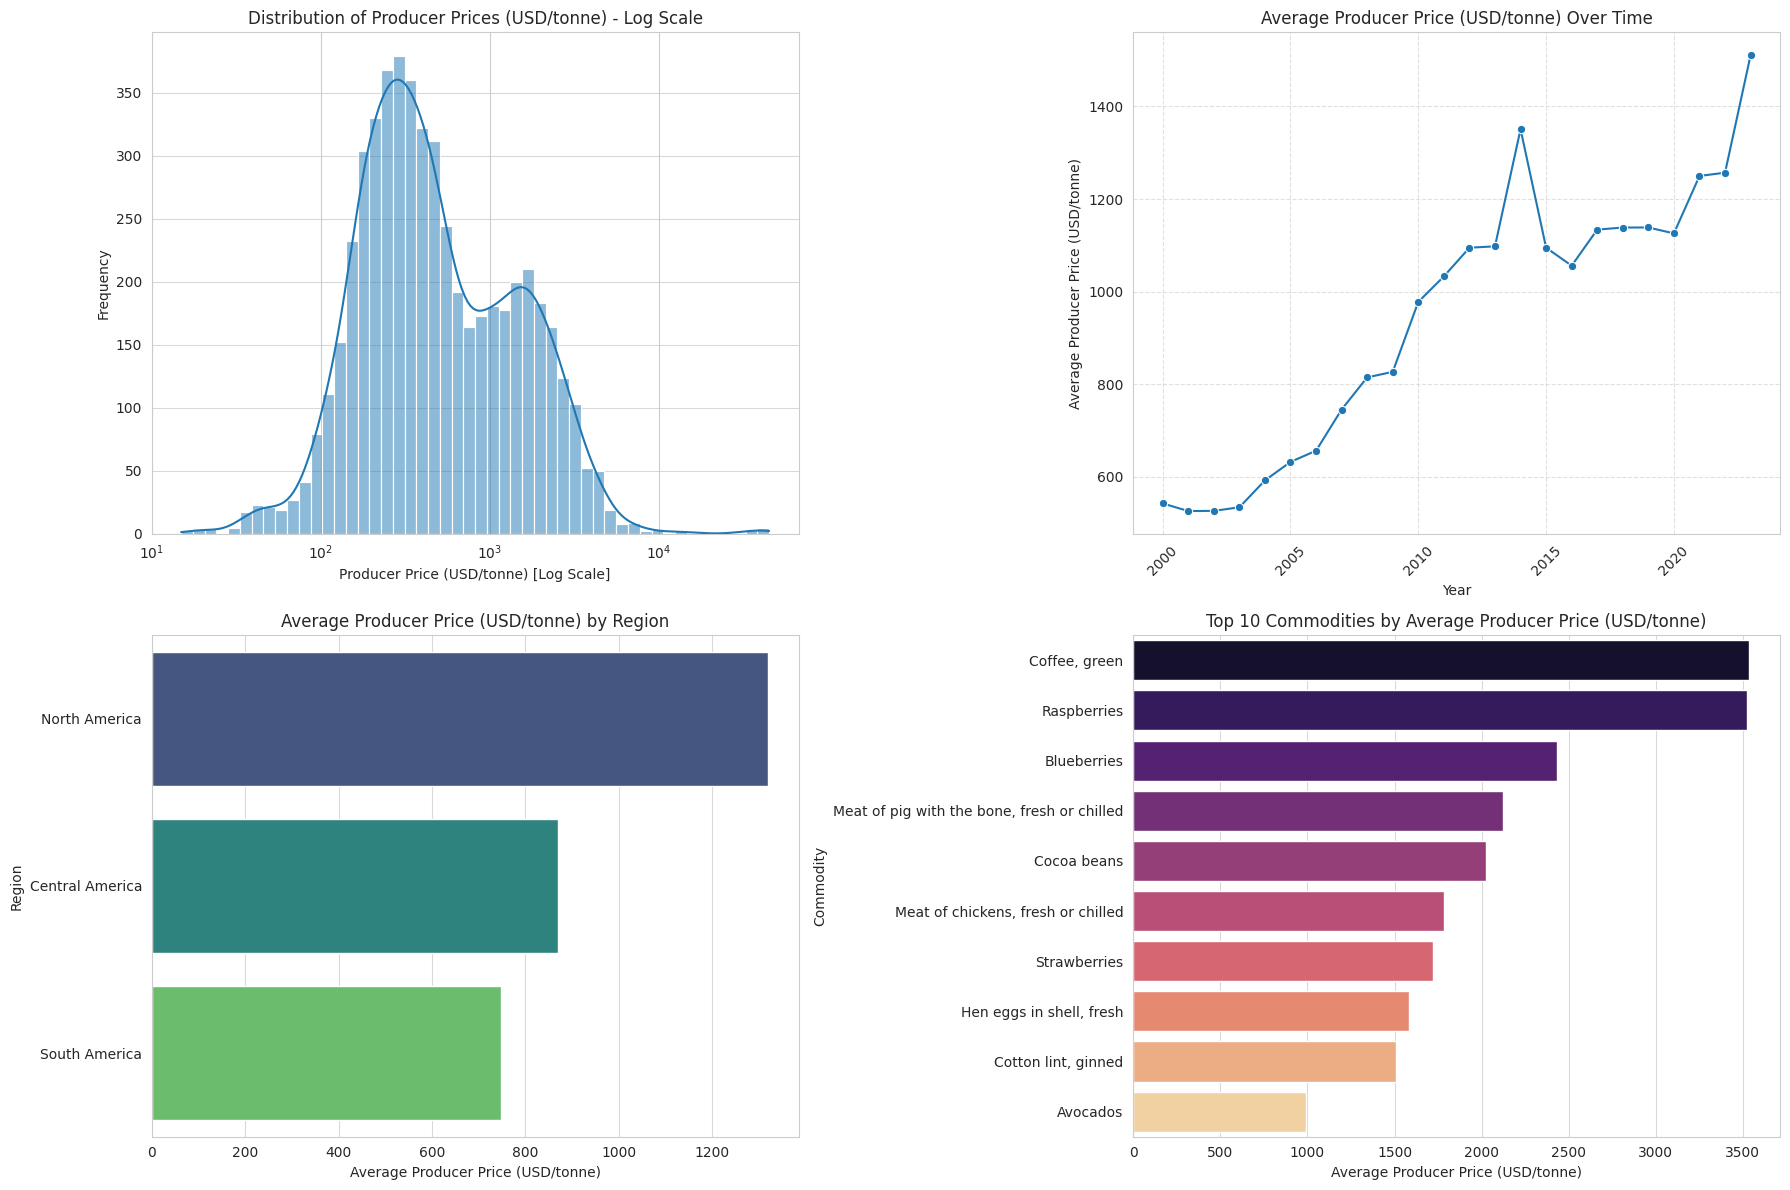


Basic visualizations generated successfully.


In [87]:
print("\n--- Generating Basic Data Visualizations ---")

if 'df' in locals() and not df.empty:

    # Set a style for the plots for better aesthetics
    sns.set_style("whitegrid")
    plt.figure(figsize=(18, 12)) # Set a larger overall figure size

    # --- Plot 1: Distribution of Producer Prices (with Log Scale) ---
    plt.subplot(2, 2, 1) # 2 rows, 2 columns, 1st plot
    # Using log_scale=True for the x-axis to better visualize skewed data
    sns.histplot(df['Producer_Price_USD_tonne'], bins=50, kde=True, log_scale=True)
    plt.title('Distribution of Producer Prices (USD/tonne) - Log Scale')
    plt.xlabel('Producer Price (USD/tonne) [Log Scale]')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)


    # --- Plot 2: Average Producer Price over Years ---
    plt.subplot(2, 2, 2) # 2 rows, 2 columns, 2nd plot
    avg_price_per_year = df.groupby('Year')['Producer_Price_USD_tonne'].mean().reset_index()
    sns.lineplot(x='Year', y='Producer_Price_USD_tonne', data=avg_price_per_year, marker='o')
    plt.title('Average Producer Price (USD/tonne) Over Time')
    plt.xlabel('Year')
    plt.ylabel('Average Producer Price (USD/tonne)')
    plt.xticks(rotation=45) # Rotate year labels for readability
    plt.grid(True, linestyle='--', alpha=0.6)

    # --- Plot 3: Average Producer Price per Region ---
    plt.subplot(2, 2, 3) # 2 rows, 2 columns, 3rd plot
    avg_price_per_region = df.groupby('Region')['Producer_Price_USD_tonne'].mean().sort_values(ascending=False).reset_index()
    sns.barplot(x='Producer_Price_USD_tonne', y='Region', hue='Region', data=avg_price_per_region, palette='viridis', legend=False)
    plt.title('Average Producer Price (USD/tonne) by Region')
    plt.xlabel('Average Producer Price (USD/tonne)')
    plt.ylabel('Region')
    plt.grid(axis='x', alpha=0.75)


    # --- Plot 4: Top 10 Commodities by Average Price ---
    plt.subplot(2, 2, 4) # 2 rows, 2 columns, 4th plot
    avg_price_per_commodity = df.groupby('Commodity')['Producer_Price_USD_tonne'].mean().nlargest(10).reset_index()
    sns.barplot(x='Producer_Price_USD_tonne', y='Commodity', hue='Commodity', data=avg_price_per_commodity, palette='magma', legend=False)
    plt.title('Top 10 Commodities by Average Producer Price (USD/tonne)')
    plt.xlabel('Average Producer Price (USD/tonne)')
    plt.ylabel('Commodity')
    plt.grid(axis='x', alpha=0.75)


    plt.tight_layout() # Adjusts plot parameters for a tight layout
    plt.show() # Display the plots

    print("\nBasic visualizations generated successfully.")

else:
    print("DataFrame 'df' is not available or is empty. Cannot generate visualizations.")



# Distribution of Producer Prices (Log Scale)
The histogram titled "Distribution of Producer Prices (USD/tonne) - Log Scale" presents the frequency of different price values in our dataset.

Logarithmic X-axis ($10^1$, 10
2
 `, etc.): The X-axis uses a logarithmic scale (base 10). This means that each major tick mark represents a power of 10. For instance:

$10^1$ corresponds to 10 USD/tonne

$10^2$ corresponds to 100 USD/tonne

$10^3$ corresponds to 1,000 USD/tonne

$10^4$ corresponds to 10,000 USD/tonne

This type of scale is crucial for visualizing data that is highly skewed to the right, like our producer prices. It compresses the wide range of very high values while expanding the lower values, allowing us to see the detailed distribution where most of the data lies.

Concentration of Data: As observed, the highest frequency of data points (where the bars are tallest, reaching up to ~400 on the Y-axis) is concentrated between 10
2
  (100 USD/tonne) and 10
3
  (1,000 USD/tonne). This indicates that the vast majority of agricultural producer prices in this dataset fall within this specific range. While there are some commodities with prices extending much higher (up to 10
4
  USD/tonne or more), they represent a smaller portion of the overall data.

This visualization effectively shows that typical producer prices are in the hundreds of USD per tonne, with fewer instances of prices in the thousands or tens of thousands.



# Average Producer Prices by Region: Key Takeaways

The visualization clearly shows a distinct hierarchy in average producer prices across the Americas: **North America leads significantly**, followed by **Central America**, and then **South America** with the lowest average.

* **North America's Premium ($1200+ USD/tonne):** This higher average likely stems from a combination of **elevated production costs** (labor, inputs, regulations), a focus on **higher-value or processed agricultural products**, and potentially **stronger market demand** within more developed economies.

* **Central America's Middle Ground ($800+ USD/tonne):** The region's intermediate position suggests a **mix of agricultural practices and commodity types**. It likely includes both more industrialized production and traditional methods, yielding prices that fall between the high-cost, high-value markets of North America and the large-volume, lower-cost production of South America.

* **South America's Lower Average ($700+ USD/tonne):** This is largely driven by its role as a major global supplier of **bulk commodities** like soybeans and corn, which inherently have lower prices per tonne. **Lower production costs** (e.g., land, labor) also contribute to these more competitive prices.

In essence, these differences reflect the **varying economic landscapes and agricultural specializations** within each region, from high-value production in the north to high-volume commodity output in the south.



# Average Producer Price Over Time: Summary of Insights

The average producer price (USD/tonne) has shown a clear **upward trend from 2000 to 2024**, with notable fluctuations:

* **Overall Uptrend (2000-2024):** This is driven by **global population growth**, increased demand, and **rising production costs** (e.g., inflation, inputs like fuel and fertilizer).
* **2014 Spike (~$1300):** This peak was likely attributed to a global commodity boom, strong demand from emerging markets, and high energy prices.

* **2016 Drop (~$1100):** A market correction occurred due to potential **oversupply**, a global economic slowdown, or falling energy prices that reduced input costs.

* **Sustained Increase (2016-2024 to ~$1600):** The strong rebound and continued rise were influenced by renewed global demand, significant **supply chain disruptions** (e.g., post-pandemic, geopolitical conflicts), persistently high input costs, and general inflationary pressures.

In essence, this trend reflects agriculture's sensitivity to global economic conditions, supply-demand balances, input expenses, and geopolitical events over the past two decades.

# Top 10 Commodities by Average Producer Price: Summary of Insights

This chart reveals which commodities command the highest average producer prices per tonne:

* **High-Value Specialty/Perishable Crops Lead:** **Coffee (green), Raspberries, and Blueberries** are at the top (approaching \$3,600 USD/tonne). Their high prices are driven by **perishability, specialized growing conditions, labor intensity, and strong consumer demand**.
* **Meat Products in the Mid-Range:** **Meat of pig** and **Meat of chickens** feature in the middle (around \$1,800 - \$2,200 USD/tonne), reflecting processing requirements and feed costs.
* **Cocoa Beans and Strawberries are Notable:** **Cocoa beans** maintain a high value due to global demand, and **Strawberries** reinforce the trend of perishable fruits commanding higher prices.
* **Lower-Priced Staples at the Bottom of this Top 10:** **Hen eggs, Cotton lint, and Avocados** (around \$900 - \$1,600 USD/tonne) represent commodities with high volume or different market dynamics compared to the top-tier items.

In essence, the highest producer prices are linked to commodities that are often delicate, require specific cultivation, are labor-intensive, or serve niche/premium markets.

---